In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os

# Add the PowerFactory Python API to the path
sys.path.append("C:/Program Files/DIgSILENT/PowerFactory 2024 SP4A/Python/3.12")

# Add the parent directory to the path to include the library
sys.path.append(os.path.join(os.getcwd(), "./")) 

# Import the PowerFactory API
from pf_python_api import PowerFactoryApp

# Start PowerFactory, load the project and show the GUI (non-interactive mode)
project_name = "SLO_EES_2024_projekt_SSSC"
app = PowerFactoryApp()
app.activate_project(project_name)
app.show_gui() # Select active project inside the GUI

PowerFactory application started successfully!
Project SLO_EES_2024_projekt_SSSC successfully activated


In [7]:
from pf_python_api.Network import Network

# Retrieve all busbars from PowerFactory project
busbars = app.get_calc_relevant_objects("*.ElmTerm")
print("All ElmTerm elements: ", len(busbars))

# Create a network object and read the busbars
network = Network()
network.read_busbars(busbars)
print("Busbars and junction nodes read from the topology: ", len(network.busbars))

All ElmTerm elements:  4441
Busbars and junction nodes read from the topology:  514


In [8]:
# Get connected elements to the busbars
network.get_connected_elements()

# Print all obtained elements types and their counts
for element_type, elements in network.classified_elements.items():
    print(f"{element_type}: {len(elements)}")

[INFO] Obtaining connected elements... in 514 busbars...
ElmLne: 490
ElmLod: 404
ElmTr2: 114
ElmCoup: 51
ElmTr3: 21
ElmSym: 56
ElmVac: 5
ElmXnet: 1
ElmZpu: 1


In [9]:
'''
Here we execute the LoadFlow command inside PF and read the results (voltage, angle) for each busbar.
'''
from typing import Dict
from powerfactory import DataObject
from pf_python_api.LoadFlowResults import BusLoadFlowResult

# Create a load flow object and execute as we need the load flow results
ldf: DataObject = app.app.GetFromStudyCase("ComLdf")
ldf.Execute() # type: ignore 

# Obtain the load flow results for each busbar
bus_load_flow_results: Dict[str, BusLoadFlowResult] = {}
for busbar in network.busbarsPF:
    name = busbar.GetAttribute("loc_name")

    try:
        voltage = busbar.GetAttribute("m:u")
        angle = busbar.GetAttribute("m:phiu")
    except Exception as e:
        print(f"Error while reading busbar {name}: {e}")
        continue
    
    bus_load_flow_results[name] = BusLoadFlowResult(
        name=name,
        voltage=voltage,
        angle=angle
    )

# Store load flow to Network object
network.read_load_flow_results(bus_load_flow_results)

In [10]:
# Here we model all the connected elements.
network.obtain_elements_data()

[WARNING] Line has less than 2 active conections. Will not include in calculations--> Line:  ENP Divača-Divača
[WARNING] Line has less than 2 active conections. Will not include in calculations--> Line:  Karbid - odc. Karbid J (Fala)
[WARNING] Line has less than 2 active conections. Will not include in calculations--> Line:  Karbid - odc. Karbid S (Fala)


In [11]:
# Calculate admittance matrix
Y_bus = network.calculate_admittance_matrix()

Number of busbars: 514
Admittance matrix shape: (514, 514)
514


In [12]:
import numpy as np
'''
In this ipynb cell we will have an ERROR if multiple generators are connected to the same main busbar!!
'''
Y_red = Y_bus

# Get generators buses
gen_bus_names = [gen.busbar_to for gen in network.synchronous_machines] # ['Bus 36G', 'Bus 33G',..]
is_gen_bus = np.array([1 if bus in gen_bus_names else 0 for bus in network.busbar_name_to_index]) # [0, 0, 1, 0, 1,..] 1 for generator bus
print(len(gen_bus_names))
print(gen_bus_names)

# Get all bus names
bus_names =  [bus for bus in network.busbar_name_to_index]

# ----------------- Sort Y_bus matrix -----------------
# Sort indices to have non-generator buses first
sorted_idx = sorted(range(len(bus_names)), key=lambda i: bus_names[i] in gen_bus_names)
print(sorted_idx)
Y_red_sorted = Y_red[np.ix_(sorted_idx, sorted_idx)]            # Reindex Y_red to have non-generator buses first and generator buses second
Y_red = Y_red_sorted                                            # Update Y_red with the sorted version

print("Y_red shape: ", Y_red.shape)

# ----------------- Build extended version of Matrix -----------------
# Navidezne generatorske zbiralke
y_red = np.eye(np.sum(is_gen_bus), dtype=complex) 
for i, gen in enumerate(network.synchronous_machines):
    y_red[i, i] = gen.Y # Fills y_red with generator admittances

# Povezave na navidezne generatorske zbiralke
y_red2 = -y_red

# Ne-generatorske zbiralke, ki nimajo povezave na generatorske zbiralke
y_dist = np.zeros((np.sum(is_gen_bus == 1), np.sum(is_gen_bus == 0)))

# print(y_red.shape)
# print(y_red2.shape)
# print(y_dist.shape)

# Zgradimo razsirjeno matriko
top_right = np.hstack((y_dist, y_red2))
bottom_left = np.vstack((y_dist.T, y_red2))
Yred = np.block([
    [y_red,         top_right],
    [bottom_left,  Y_red     ]
])
YredX = Yred

print("Shape of extended matrix YredX: ", np.shape(YredX))

56
['HE Bostanj (10_5 kV) 1', 'HE Brezice (10.5 kV) 1', 'Medvode (6.3 kV) 1', 'Medvode (6.3 kV) 2', 'Moste (6.3 kV) 1', 'Solkan (6.3 kV) 1', 'Vrhovo (6.3 kV) 1', 'Doblar B3', 'Krsko (21 kV)', 'NG', 'NG(1)', 'NG(10)', 'NG(11)', 'NG(12)', 'NG(13)', 'NG(14)', 'NG(15)', 'NG(17)', 'NG(18)', 'NG(2)', 'NG(20)', 'NG(21)', 'NG(22)', 'NG(23)', 'NG(24)', 'NG(25)', 'NG(26)', 'NG(3)', 'NG(4)', 'NG(5)', 'NG(6)', 'NG(7)', 'NG(8)', 'NG(9)', 'Node HE Krsko G1', 'NodeGen', 'NodeGen(1)', 'NodeGen(10)', 'NodeGen(11)', 'NodeGen(12)', 'NodeGen(2)', 'NodeGen(3)', 'NodeGen(4)', 'NodeGen(5)', 'NodeGen(6)', 'NodeGen(7)', 'NodeGen(8)', 'NodeGen(9)', 'Plave G1 B', 'Plave G2 B', 'TE-TOL ETL01A', 'Terminal(50)', 'Terminal(65)', 'Vuzenica G2 B', 'ZB_TEB_PB7', 'ŽŽ_Šoštanj G6']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 6

In [13]:
# KRON'S REDUCTION
def KronReduction3(Y, p):
    # Extracting sub-blocks
    Y_RR = Y[:p, :p]
    Y_RL = Y[:p, p:]
    Y_LR = Y[p:, :p]
    Y_LL = Y[p:, p:]
    
    # Compute the inverse of Y_LL
    Y_LL_inv = np.linalg.inv(Y_LL)
    
    # Compute Y_Reduced using the Schur complement
    Y_Reduced = Y_RR - Y_RL @ Y_LL_inv @ Y_LR

    return Y_Reduced

num_gen_buses = np.sum(is_gen_bus)                                      # Calculate the number of generator buses
num_total_buses = Y_red.shape[0]                                        # Calculate the total number of buses
red_id = np.arange(num_gen_buses, num_total_buses + num_gen_buses)      # Generate the indices to reduce

print("Performing Kron's Reduction... on YredX shaped: ", np.shape(YredX), " with num_gen_buses: ",num_gen_buses)
Y_reduced = KronReduction3(YredX, num_gen_buses)
print("After Kron's Reduction we obtain Y_reduced with shape: ", np.shape(Y_reduced))

# for row in Y_reduced:
#     print("    ".join(f"{val:.5f}" for val in row))

Performing Kron's Reduction... on YredX shaped:  (570, 570)  with num_gen_buses:  56
After Kron's Reduction we obtain Y_reduced with shape:  (56, 56)


In [14]:
# GET GENERATORS DATA required for calculation of the synchronizing power coefficients
generator_order = gen_bus_names

# Get generator VOLTAGE AND IMPEDANCE
V_gens = np.zeros(len(generator_order), dtype=complex)
Z_gens = np.zeros(len(generator_order), dtype=complex)
for i, bus_name in enumerate(generator_order):
    for gen in network.synchronous_machines:
        if gen.busbar_to == bus_name:
            bus_name = gen.busbar_to

            # Get voltage and angle
            V = bus_load_flow_results[bus_name].voltage
            phi = bus_load_flow_results[bus_name].angle
            
            V_complex = V * (np.cos(np.radians(phi)) + 1j * np.sin(np.radians(phi)))
            V_gens[i] = V_complex

            Z = 1 / gen.Y
            Z_gens[i] = Z
            break

# GET GENERATOR ACTIVE AND REACTIVE POWER
P_gens = np.zeros(len(generator_order))
Q_gens = np.zeros(len(generator_order))
for i, bus_name in enumerate(generator_order):
    for gen in network.classified_elements['ElmSym']:
        # Check if the generator is in service
        is_in_service =gen.GetAttribute("outserv")
        if is_in_service == 1:
            continue

        connections = gen.GetConnectedElements(1, 1, 1)
        if len(connections) != 1:
            print("[WARNING] SynMachine has none more than one connection --> SynMachine: ", gen.GetAttribute('loc_name'))
            continue
        connected_bus = connections[0]
        gen_bus_name = connected_bus.GetAttribute("loc_name")


        # Check if the generator is the one we are looking for
        if gen_bus_name == bus_name:
            P = gen.GetAttribute("m:P:bus1")
            Q = gen.GetAttribute("m:Q:bus1")
            P_gens[i] = P
            Q_gens[i] = Q
            break

# print(P_gens)
# print(Q_gens)

# Calculate generators VOLTAGE AND ANGLE
E = np.where(V_gens != 0, V_gens + Z_gens * (np.conj(P_gens + 1j * Q_gens) / np.conj(V_gens)), 0)
E_abs = np.abs(E)
E_angle = np.angle(E)

In [15]:
# Calculate the synchronizing power coefficients
DistBusName = "Krsko (21 kV)"   # Disturbance bus name (NEK)
DistBus = gen_bus_names.index(DistBusName) # Disturbance bus index

print("DistBus index: ", DistBus)

B_K = np.imag(Y_reduced)
G_K = np.real(Y_reduced)

# Create the coefficient matrix K
K = (np.ones(Y_reduced.shape) * E_abs[DistBus] * E_abs *
     (B_K * np.cos(np.deg2rad(E_angle - np.ones(Y_reduced.shape)*E_angle[DistBus])) -
      G_K * np.sin(np.deg2rad(E_angle - np.ones(Y_reduced.shape)*E_angle[DistBus]))))
K[np.isnan(K)] = 0 # Replace NaN values with zero

# Reference is SG bus
K = K[:, DistBus] # Select the column at DistBus from matrix
K[DistBus] = 0 # Set the element at DistBus to zero
print(np.sum(K) )
ratios = K / np.sum(K) # Compute ratios

DistBus index:  8
674.0953061624875


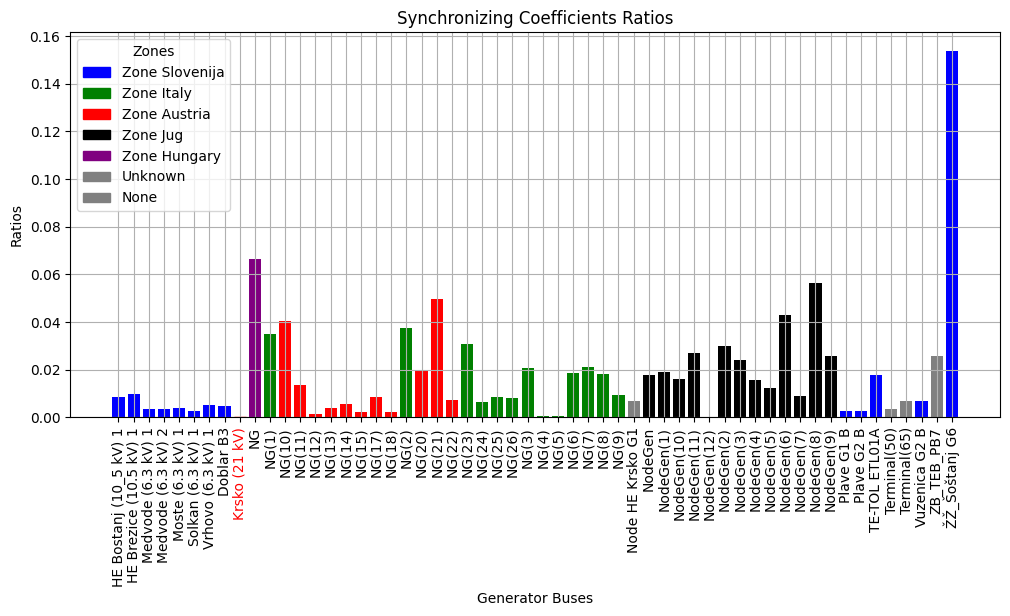

In [16]:
# Plot the ratios
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Define a function to get the zone of a generator
def get_zone(generator_name):
    generator_zones = {}
    for gen in network.synchronous_machines:
        gen_name = gen.busbar_to
        zone = gen.zone 
        generator_zones[gen_name] = zone
    return generator_zones.get(generator_name, "Unknown")

# Get the zones for each generator
generator_zones = [get_zone(gen) for gen in generator_order]

# Define colors for the bars based on zones
zone_colors = {
    "Zone Slovenija": "blue",
    "Zone Italy": "green",
    "Zone Austria": "red",
    "Zone Jug": "black",
    "Zone Hungary": "purple",
    "Unknown": "gray",
    "None": "gray"
}

plt.figure(figsize=(12, 5))
bars = plt.bar(generator_order, ratios, color=[zone_colors[get_zone(gen)] for gen in generator_order])
plt.xlabel('Generator Buses')
plt.ylabel('Ratios')
plt.title('Synchronizing Coefficients Ratios')
plt.xticks(rotation=90)
plt.grid(True)

# Customize the x-tick labels
for bar, gen in zip(bars, generator_order):
    if DistBusName == gen:
        bar.set_color('red')
        plt.gca().get_xticklabels()[generator_order.index(gen)].set_color('red')

# Add legend
handles = [Rectangle((0,0),1,1, color=color) for color in zone_colors.values()]
labels = zone_colors.keys()
plt.legend(handles, labels, title="Zones")
plt.show()

C:\Users\Martin\AppData\Local\Temp\ipykernel_3764\3712658630.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ordered_values_at_min_index = [values_at_dist_index[generator_names_list.index(gen)] for gen in gen_names]
C:\Users\Martin\AppData\Local\Temp\ipykernel_3764\3712658630.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ordered_values_before_min_index = [values_before_dist_index[generator_names_list.index(gen)] for gen in gen_names]


264.8588420099996


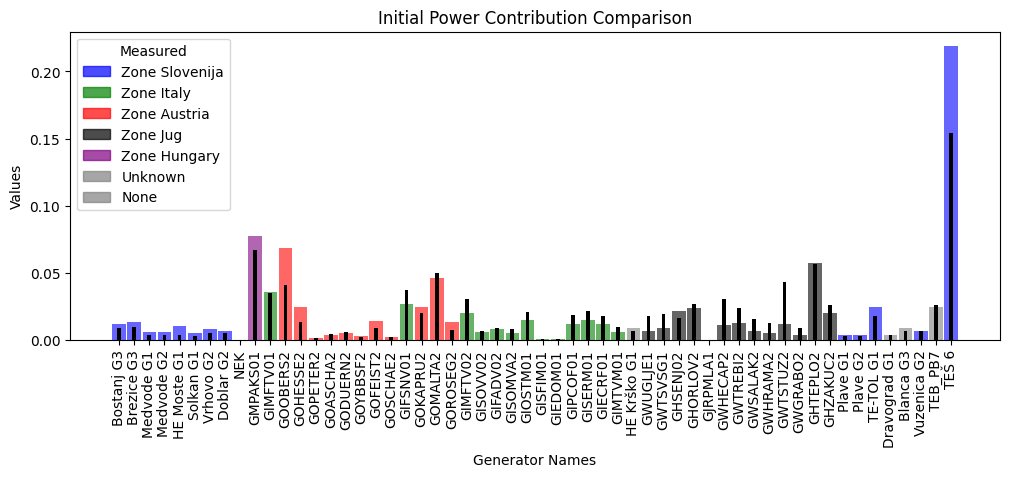

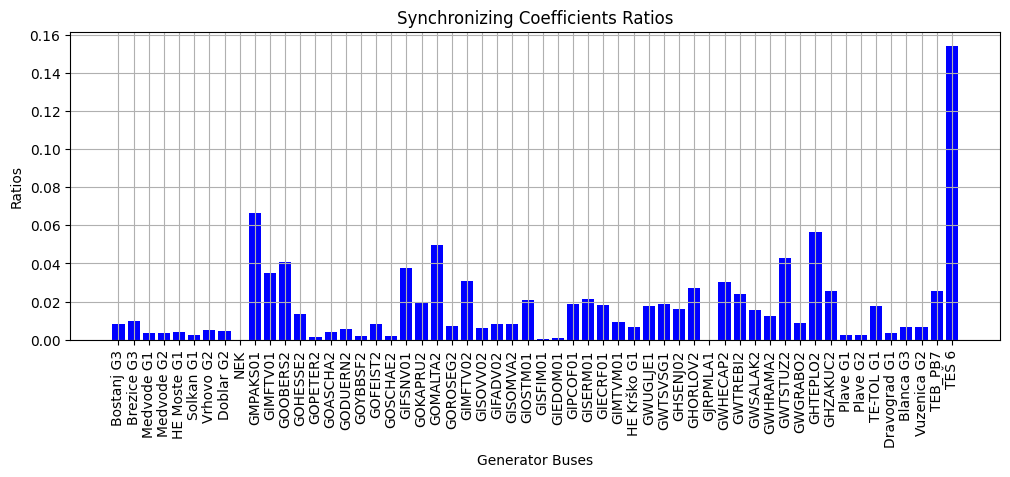

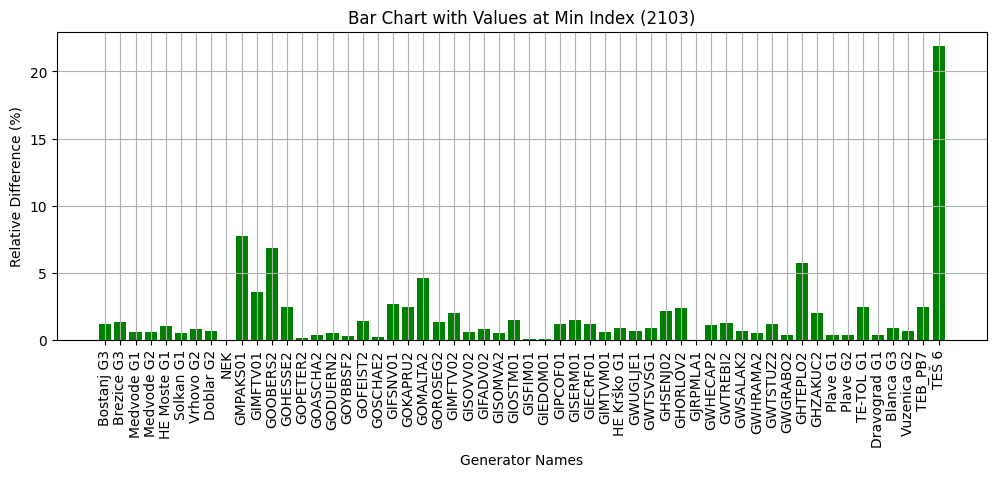

In [17]:
# READ RMS Results
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

gen_name_out = "NEK"
file_path = f'./rms_results/martin_scenario/results_izpad_{gen_name_out}.csv'

# Read the CSV file
data = pd.read_csv(file_path, delimiter=';', decimal=',')

# Extract the generator names from the first row
generator_names_list = data.columns[1:].tolist()  # Skip the first column which is "Time in s"
time_values = data.iloc[:, 0].tolist()

# Get the values for generators at 
dist_index = 2103 # Extract manually from the simulation data (distrubance-index)
values_at_dist_index = data.iloc[dist_index, 1:].str.replace(',', '.').astype(float)
values_before_dist_index = data.iloc[dist_index - 1, 1:].str.replace(',', '.').astype(float)

# Reorder the generator names and values to match the order of gen_names
gen_names = [gen.name for gen in network.synchronous_machines]
ordered_values_at_min_index = [values_at_dist_index[generator_names_list.index(gen)] for gen in gen_names]
ordered_values_before_min_index = [values_before_dist_index[generator_names_list.index(gen)] for gen in gen_names]

# Calculate the difference and relative difference
substraction = np.array(ordered_values_at_min_index) - np.array(ordered_values_before_min_index)
gen_out_index = gen_names.index(gen_name_out)
substraction[gen_out_index] = 0
rdP = substraction / sum(substraction) * 100  # Convert to percentage
print(sum(substraction))


# Create the first bar chart with both results on the same axis
bar_width_1 = 0.25  # Width of the first set of bars
bar_width_2 = 0.9  # Width of the second set of bars

plt.figure(figsize=(12, 4))
bar2 = plt.bar(np.arange(len(gen_names)), rdP/100, bar_width_2, color=[zone_colors[get_zone(gen)] for gen in generator_order], label='Measured', alpha=0.6)
bar1 = plt.bar(np.arange(len(gen_names)), ratios, bar_width_1, color='black', label='Calculated', alpha=1)

plt.xlabel('Generator Names')
plt.ylabel('Values')
plt.title('Initial Power Contribution Comparison')
plt.xticks(np.arange(len(gen_names)), gen_names, rotation=90)
# Add legend
handles = [Rectangle((0,0),1,1, color=color, alpha=0.7) for color in zone_colors.values()]
labels = zone_colors.keys()
plt.legend(handles, labels, title="Measured")
plt.grid(False)
plt.show()

# Calcualted ratios bar chart
plt.figure(figsize=(12, 4))
plt.bar(gen_names, ratios, color='blue')
plt.xlabel('Generator Buses')
plt.ylabel('Ratios')
plt.title('Synchronizing Coefficients Ratios')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

# Measured values bar chart at disturbance index
plt.figure(figsize=(12, 4))
plt.bar(gen_names, rdP, color='green')
plt.xlabel('Generator Names')
plt.ylabel('Relative Difference (%)')
plt.title(f'Bar Chart with Values at Min Index ({dist_index})')
plt.xticks(rotation=90)
# plt.ylim(0, 100)  # Set y-axis limits from 0 to 100%
plt.grid(True)
plt.show()
